In [1]:
from itertools import permutations
from random import shuffle

import tensorflow as tf
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [65]:
learning_rate = 0.001
num_steps = 100
batch_size = 16
display_step = 1000
n_epochs = 42

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 128 # 2nd layer number of neurons
num_input = 2 
num_classes = 1

#Equation Parameters
D = 1
C0 = -0.1


# tf Graph input
X = tf.placeholder("float", [None, 1])
T = tf.placeholder("float", [None, 1])

In [66]:
x = np.linspace(start=0,stop=10,num=100).reshape(-1,1)
t = np.linspace(start=0,stop=100,num=100).reshape(-1,1)

In [67]:
weights = {
    'h1': tf.Variable(tf.random_normal([num_input, n_hidden_1])),
    #'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_1, num_classes]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([num_classes]))
}


In [68]:
# Create model
def neural_net(x,t):
    netin = tf.concat([x,t],1)
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.add(tf.matmul(netin, weights['h1']), biases['b1'])
    # Hidden fully connected layer with 256 neurons
    layer_1 = tf.nn.sigmoid(layer_1)
    out_layer = tf.matmul(layer_1, weights['out']) + biases['out']
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

In [69]:
zero = X*0.0
net = neural_net(X, T)
net_dt = tf.concat(tf.gradients(xs = [T],ys = net), 1)
net_dx1 = tf.concat(tf.gradients(xs = [X], ys = net), 1)
net_dx2 = tf.concat(tf.gradients(xs = [X], ys = net_dx1), 1)
net_dx0 = tf.concat(tf.gradients(xs = [zero],ys = neural_net(zero,T)), 1)

In [70]:
loss_op = tf.square(D*net_dx2-net_dt)+tf.square(net_dx0*D-C0)+tf.square(neural_net(X,zero))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

In [71]:
class BatchGenerator:
    def __init__(self, n_samples, batch_size):
        self.n_samples = n_samples
        self.idx = list(range(n_samples))
        shuffle(self.idx)
        self.current = 0
        self.batch_size = batch_size
        self.iter = permutations(self.idx,2)
    
    def __len__(self):
        return int(self.n_samples**2/self.batch_size)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        idx,idt = [],[]
        for i in range(self.batch_size):
            x, t = next(self.iter)
            idx.append(x)
            idt.append(t)
        return idx,idt

In [72]:
init = tf.global_variables_initializer()
losses = []
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        batch_generator = BatchGenerator(n_samples=x.shape[0],batch_size=batch_size)
        for batch_idx,batch_idt in tqdm(batch_generator):
            #batch_idx = np.random.randint(low=0,high = x.shape[0],size = batch_size)
            #batch_idt = np.random.randint(low=0,high = x.shape[0],size = batch_size)
            batch_x = x[batch_idx]
            batch_t = t[batch_idt]
            sess.run(train_op, feed_dict={X: batch_x, T: batch_t})
        # Calculate batch loss and accuracy
        loss = sess.run(loss_op, feed_dict={X: batch_x,T: batch_t})
        #print("Step " + str(step) + ", Minibatch Loss= " + "{:.4f}".format(loss))
        losses.append(loss)
        #print(loss)
    saver.save(sess, './solution.ckpt')

 99%|█████████▉| 618/625 [00:01<00:00, 553.78it/s]


In [73]:
losses

[array([[5.81206732e-05],
        [1.94967113e-04],
        [2.30084697e-04],
        [1.76267946e-04],
        [3.96509640e-05],
        [5.21867012e-04],
        [1.00799174e-04],
        [5.22716437e-05],
        [3.26342197e-05],
        [2.45504580e-05],
        [1.68437924e-04],
        [6.87331922e-05],
        [4.42853525e-05],
        [1.30786543e-06],
        [7.20915996e-05],
        [1.92737367e-04]], dtype=float32), array([[1.05680374e-04],
        [7.12256078e-05],
        [2.30734586e-04],
        [2.21338792e-04],
        [1.97011046e-04],
        [7.04136328e-05],
        [2.62940448e-05],
        [2.16214379e-04],
        [5.66603011e-03],
        [5.40268957e-05],
        [7.84243166e-05],
        [5.37806372e-05],
        [1.97261455e-04],
        [1.29145483e-04],
        [1.82778254e-04],
        [9.87832664e-06]], dtype=float32), array([[1.3750156e-04],
        [1.5997506e-05],
        [4.7065422e-04],
        [5.5771587e-05],
        [4.3246199e-04],
        [6.

In [74]:
init = tf.global_variables_initializer()
#tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess,'./solution.ckpt')
    x_in = x.reshape(-1,1)
    t_in = 50.0*np.ones(x.shape[0]).reshape(-1,1)
    profile = sess.run(net, feed_dict={X:x_in,T:t_in})

INFO:tensorflow:Restoring parameters from ./solution.ckpt


In [75]:
def compute_profile(time, model_path='./solution.ckpt'):
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        saver.restore(sess,'./solution.ckpt')
        x_in = x.reshape(-1,1)
        t_in = time*np.ones(x.shape[0]).reshape(-1,1)
        profile = sess.run(net, feed_dict={X:x_in,T:t_in})
    return profile

In [76]:
profile = compute_profile(0)

INFO:tensorflow:Restoring parameters from ./solution.ckpt


In [77]:
np.mean(profile)

0.00051133963

INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt
INFO:tensorflow:Restoring parameters from ./solution.ckpt


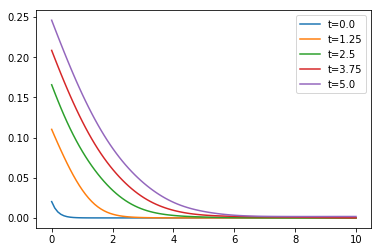

In [78]:
times = np.linspace(0,5,5).tolist()
legend = []
for time in times:
    profile = compute_profile(time)
    plt.plot(x,profile)
    legend.append(f"t={time}")
plt.legend(legend)
plt.show()